<a href="https://colab.research.google.com/github/3minuterecord/myJup/blob/master/MTG_GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine Tune GPT-2 for Safety Incident Narrative Generation.

Use [PyTorch](https://pytorch.org/) and Transformers from [Hugging Face](https://huggingface.co/) to fine tune a [GPT-2 Model](https://openai.com/blog/gpt-2-1-5b-release/) to fabricate fake 'topic specific' incident descriptions. The intention is to use these fabricated incident descriptions to augment training data for supervised topic classification models.

Code chunk references:
- [Rey Farhan](http://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)
- [Chris McCormick's](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) BERT fine-tuning tutorial
- [Ian Porter's](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) GPT2 tutorial 
- [Hugging Face](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) Language model fine-tuning script.

**NOTE**
Check this repo for possibly some good examples on transformer based augmentation

https://blog.paperspace.com/data-augmentation-for-nlp/

In [1]:
# Mount Google drive to access datasets.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


### Load Data & Support Packages

- Install the Huggingface transformers library. 
- Installing transformers will also install tokenizers (a dependency and another useful set of tools for this task).

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import numpy as np
import pandas as pd
import re
import pickle
import random

import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
from tqdm.std import tqdm
from math import ceil

In [5]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    'hydraulic fluid or oil leak_577_out_df_temp',
    'line strike_326_out_df_temp',
    'site compliance or practice issue_400_out_df_temp',
    'ppe non-compliance_144_out_df_temp',
    'mechanical or equipment issue_471_out_df_temp'
]

lang_models = [
    '2209211609_hydraulic fluid or oil leak_language_model',
    'line',
    '2210031409_site compliance or practice issue_language_model',
    'ppe',
    'mech'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Topic-specific datasets were created using the rule-book classification method
# in a previous analysis step. We are interested here in topics that are rare but
# important as they are safety leading indicators (SLIs)
sample_name = f'df_train_trues_{focus_cat}' 
reports = pd.read_csv(f"01_data/prepared/{sample_name}.csv", dtype=str)  
reports

Pick a category: line strike


,Unnamed: 0,text,category
0,285,dc cable struck allied fencing employees repor...,1
1,791,it was notice that part of the bank had collap...,1
2,819,plate compactor was damaged when operator turn...,1
3,824,excavator made contact with two empty one inch...,1
4,1252,as the equipment operator began to dig into th...,1
...,...,...,...
256,86830,contact with hot objects or substances a contr...,1
257,89205,direct exposure to electricity greater than tw...,1
258,91291,indirect exposure to electricity unspecified a...,1
259,92988,direct exposure to electricity unspecified emp...,1


In [6]:
# Filter out rows that are not classified as the topic of interest 
# and remove unecessary columns.
#reports = reports[reports.category != '*** Not Classified']
reports = reports[['text']]
reports = reports['text']
reports

0      dc cable struck allied fencing employees repor...
1      it was notice that part of the bank had collap...
2      plate compactor was damaged when operator turn...
3      excavator made contact with two empty one inch...
4      as the equipment operator began to dig into th...
                             ...                        
256    contact with hot objects or substances a contr...
257    direct exposure to electricity greater than tw...
258    indirect exposure to electricity unspecified a...
259    direct exposure to electricity unspecified emp...
260    direct exposure to electricity greater than tw...
Name: text, Length: 261, dtype: object

In [7]:
# Print a radom example as a spot check
select_random_row = random.randint(0, len(reports))
reports.iat[select_random_row]

'bt cable struck during excavation during digging activities to lay virgin media ducting a bt cable was struck by the mini digger the work was stopped bt informed rest of the area hand dug to identify further cable'

### GPT2 Tokenizer


What is a Tokenizer? (Ref. [Tokenizers](https://github.com/huggingface/tokenizers))
```
A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

Start by using the GPT-2 tokenizer to tokenize the report text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but this can be set differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. 

In [8]:
# Instantiate our tokenizer 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

# Generate an example encoding
# Example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the 
# string, in this case one numeric value per word. These values are easier to train the 
# neural network model on than the string representation.
tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

In [9]:
# Inspect to find the longest string, this is required later to determine pad length for sentences.
max_report = max([len(tokenizer.encode(report)) for report in reports])
print(f'The longest report text is {max_report} tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1724 > 1024). Running this sequence through the model will result in indexing errors


The longest report text is 1724 tokens long.


In [10]:
# Set a word count cut to avoid memory issues
# As per word count analysis reports with less than 300 words cover 95 percentile
word_count_cut = int(input('Enter word count cut (default = 800): '))
reports = [' '.join(item.split()[:word_count_cut]) for item in reports if item]
new_max_report = max([len(tokenizer.encode(report)) for report in reports])
print(f'The longest report text is {new_max_report} tokens long.')

Enter word count cut (default = 800): 800
The longest report text is 987 tokens long.


### PyTorch Datasets & Dataloaders

Different language models require different amounts of memory to hold all of the weights and biases in memory. The memory available will impact batch size.  

In [11]:
!nvidia-smi

Fri Oct  7 20:54:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# Model requires significant memory, start with batch size equal to 1
# TODO - Investigate why such a large memory requirement.
bs = 1

Batch size affects training time so better to set the batch to the highest number that can be fit in the memory of the GPU used for training. However, BS should only affect training time but not model performance.

Now create a custom dataloader for the corpus following the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation.

In [13]:
class safety_dataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_report):
    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the safety text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

TODO - Investigate the maximum length of tokens (768?) that the tokenizer can handle. To save space in the model we ususally only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. 

Firstly, you might wonder is why we’re ensuring that we chop our strings at 768 characters. We’re going to be using gpt2-small in this chapter, which has that limitation due to its hidden dimensionality of 768 (if you want to use larger pre-trained models, then you can increase this: gpt2-medium/1024, gpt2-large/1280, gpt2-xl/1600). Of course, because this dataset is only tweets, we’re never going to bump up against the limit, but I thought I would I’d include it so you know to be aware of the limitation.

In [14]:
dataset = safety_dataset(reports, tokenizer, max_length=new_max_report)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 234 samples for training, and 27 samples for validation testing'

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [15]:
# Each entry in the dataset will be two tensors,
# - one which is the encoding for the string 
# - one which is the attention mask. 
# The dataset will then be split into the training and validation sets.
dataset[0]

(tensor([50257, 17896,  7862,  7425, 22034, 39244,  4409,  2098, 13456,   281,
         12278,  6380,   981, 15975,  6851,   351,   257,   279,   710, 16735,
          5059,  3335, 47980,   273,  4409,   547,  5059,   257, 13990,  1281,
         25137,   257,   279,   710, 16735,  4639,   981,  5059,   262,  1281,
          1111,  4409,  2098,  6464,   257,  6380,   477,   670,   373,  3393,
          5025,   262,  1989, 31853,  5286,   290,   477,  1176,   287,   262,
          2512,   390,   877,    70,  1143,   262,  4409,   547,  6515,   319,
         15654,   290,   329, 32992,   560,  3840, 18665,   284,   257,  1957,
          3315,  6841,   329,  2252,  3315, 12660,   290,  2716,   262,  4238,
          3645,  5071,   326,   262,  1281,  1625,   656,  2800,   351,   281,
         19647,  1143, 30736,  3745,   263,  7862,   262,  1627,  4067,   373,
          7498,  2029,  2323,  2884,  6056,  2667,   290,   319,  2810, 23388,
           262, 47980,   273,   750,   407,  1061,  

In [29]:
int(dataset[0][0][-1])

50258

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [16]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [17]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [19]:
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""
total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

In [21]:
# Print device setting and memory allocations
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.5 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()  

        outputs = model(b_input_ids, labels=b_labels, attention_mask = b_masks, token_type_ids=None)
        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1, 30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id
                                )
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4
Batch 100 of 234. Loss:0.10239511728286743. Time:0:00:41
Batch 200 of 234. Loss:0.3449487090110779. Time:0:01:23
Average Training Loss: 0.48159576793256986. Epoch time: 0:01:38
Validation loss: 0.6883598094185194. Validation Time: 0:00:03
Beginning epoch 2 of 4
Batch 100 of 234. Loss:0.3985072672367096. Time:0:00:40
Batch 200 of 234. Loss:0.9810633063316345. Time:0:01:21
Average Training Loss: 0.48180914687741005. Epoch time: 0:01:36
Validation loss: 0.6883598094185194. Validation Time: 0:00:03
Beginning epoch 3 of 4


Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

In [ ]:
!matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_language_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

### Generate Fake Text

In [ ]:
# Printing long descriptions in Colab can be messy as they don't wrap
# Create simple function to split lines to set length
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while  (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    return output

In [ ]:
# load the model from disk
lang_model_ref = lang_models[index]
lang_model = pickle.load(open(f'08_output/models/{lang_model_ref}.pkl', 'rb'))

In [ ]:
# Start by just generating a fake narrative using the trained model and no prompt text.
how_many_examples = 1
lang_model.eval()
prompt = "<|startoftext|>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = lang_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=how_many_examples,
                                pad_token_id = tokenizer.eos_token_id
                                )

for i, sample_output in enumerate(sample_outputs):
    fab_txt = split_input(tokenizer.decode(sample_output, skip_special_tokens=True), 80)
    for r, chunk in enumerate(fab_txt):
        if r == 0:
            head_txt = f'\nFake {i+1}:'
            print(head_txt)
            print('-'*(len(head_txt)-1))
            print(chunk)    
        else:
            print(chunk)


Fake 1:
-------
other fall to lower level twenty-one to thirty feet an employee was installing
shin tags on a chain link fence post when he was injured suffering from an
episode of broken ribs and multiple surgeries fall protection was not worn at
the time


In [ ]:
# Now lets use actual prompts designed for the focus group
# Load the prompts file created using separate scripts
prompts_file = pd.read_csv("04_rule_book/prompts.csv")

def clean_prompts(in_str):
    out_str = re.sub('\\[', '', in_str)
    out_str = re.sub('\\]', '', out_str)
    out_str = re.sub("'", '', out_str)
    out_str = out_str.split(", ")
    return(out_str)

In [ ]:
prompts_file

,group,counts,prompts
0,competency,128,apprentice did not receive correct training_ c...
1,fall from or working at height issue,0,NaN
2,dropped object or material,78,bolt fell_ box fell_ crate fell_ debris fell_ ...
3,mechanical or equipment issue,72,bolt fault_ connector fault_ connection fault_...
4,fuel spill or leak,0,NaN
5,hydraulic fluid or oil leak,792,there was a leak_ there was a loss_ there was ...
6,hazardous materials or work,0,NaN
7,environmental leak or issue,0,NaN
8,line strike,672,digger burst buried pipe_ digger burst buried ...
9,ppe non-compliance,192,apprentice not wearing correct gloves_ apprent...


In [ ]:
prompts_for_group = prompts_file[prompts_file['group'] == focus_cat]
prompts_for_group

,group,counts,prompts
10,site compliance or practice issue,841,good practice not applied_ good practice not f...


In [ ]:
# Create a list of prompts for the focus group only
num_unique_prompts = prompts_for_group['counts'].iloc[0]
print(f"There are {num_unique_prompts} unique prompts...")
prompts_list = prompts_for_group['prompts'].iloc[0].split('_ ')

There are 841 unique prompts...


In [ ]:
# Quick visual inspection of prompts
prompts_list

['good practice not applied',
 'good practice not followed',
 'good practice not observed',
 'good practice not respected',
 'normal practice not applied',
 'normal practice not followed',
 'normal practice not observed',
 'normal practice not respected',
 'site practice not applied',
 'site practice not followed',
 'site practice not observed',
 'site practice not respected',
 'permit not applied',
 'permit not followed',
 'permit not observed',
 'permit not respected',
 'procedure not applied',
 'procedure not followed',
 'procedure not observed',
 'procedure not respected',
 'process not applied',
 'process not followed',
 'process not observed',
 'process not respected',
 'good practice non conformance',
 'normal practice non conformance',
 'site practice non conformance',
 'permit non conformance',
 'procedure non conformance',
 'process non conformance',
 'good practice non compliance',
 'normal practice non compliance',
 'site practice non compliance',
 'permit non compliance',


In [ ]:
# Now loop through and create n different narratives from each prompt
# using the language model decoder
all_fab_txts = []
ECHO=False

# Create n different narratives per prompt...
# Target n number of augments so that there is consistency betweem groups when evaluating impact
# of the augmentation
target_num_of_augs = 8000
HOW_MANY_PER_PROMPT = ceil(target_num_of_augs / num_unique_prompts)
print(f'Faking: {focus_cat}')
print(f'Generating {HOW_MANY_PER_PROMPT} x {num_unique_prompts} fake narratives...')

for p in tqdm(prompts_list):
    how_many_examples = HOW_MANY_PER_PROMPT
    lang_model.eval()
    prompt = "<|startoftext|>"+p
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = lang_model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length=400,
                                    top_p=0.95, 
                                    num_return_sequences=how_many_examples,
                                    no_repeat_ngram_size=2,
                                    pad_token_id = tokenizer.eos_token_id
                                    )

    for i, sample_output in enumerate(sample_outputs):
        fab_txt = tokenizer.decode(sample_output, skip_special_tokens=True)
        all_fab_txts.append(fab_txt)
        if ECHO:
            fab_txt = split_input(fab_txt, 80)
            for r, chunk in enumerate(fab_txt):
                if r == 0:
                    head_txt = f'\nFake {i+1}:'
                    print(head_txt)
                    print('-'*(len(head_txt)-1))
                    print(chunk)    
                else:
                    print(chunk)

df_fab_txts = pd.DataFrame(all_fab_txts, columns = ['text'])
df_fab_txts['group'] = focus_cat

Faking: site compliance or practice issue
Generating 10 x 841 fake narratives...


100%|██████████| 841/841 [1:29:29<00:00,  6.38s/it]


In [ ]:
# Check the the number of fake narrratives (should be n x unique prompt count)
rep_count = len(df_fab_txts)
print('No. of fabricated reports: ', rep_count)

# Now write the fake data to the 'fabricated' subfolder of the data folder
# This data will be used for transformer-based data augmentation (TrDA)
df_fab_txts.to_csv(f'01_data/fabricated/{focus_cat}_{rep_count}_trda.csv', index=False)
df_fab_txts

No. of fabricated reports:  8410


,text,group
0,good practice not applied at time of incident ...,site compliance or practice issue
1,good practice not applied to individual due to...,site compliance or practice issue
2,good practice not applied by employee not obse...,site compliance or practice issue
3,good practice not applied by superintendent su...,site compliance or practice issue
4,good practice not applied to non compliance wi...,site compliance or practice issue
...,...,...
8405,failure to respect process life saving rule br...,site compliance or practice issue
8406,failure to respect process on one thousand and...,site compliance or practice issue
8407,failure to respect process or procedure or met...,site compliance or practice issue
8408,failure to respect process authority incident ...,site compliance or practice issue


In [ ]:
# Now visually inspect a random sample of 20
from IPython.display import display, HTML
table = df_fab_txts.sample(20)
display(HTML(table.to_html()))

,text,group
4753,lady did not apply good practice to the client lsr incident 30616client received a generic authorization from an employee to monitor a client iw that had been created to offer a monthly oc audit for purposes of client management this morning client had obtained a db access key to access a iwi project for review purposes this activity was carried out by a contract auditor without any prior approval the ibc authorization was issued only by contractor auditor who had never was aware of this authorization the bsp was approved but by client it was not practical to issue an ibcsn authorization but not as such the employee was observed using his personal iwe and observed by the contractor overseeing the operations while observing this incident as it relates to client investigation it is important that clients understand that they can obtain an access pass for the iwork and therefore they are not allowed to request a pass by reason of their existence and client response the decision to not to provide this info was made based on client understanding of what was happening and it did no good to make people aware client immediately made the request to log in on the lmsc to and reviewed it immediately after the review of the activity the process of creating a lng for a task was unclear for this client and while the task description did provide some robertson and michael gillespie as ln contractors the requirement for an email address at approximately 1pm to conduct the audit was clearly communicated to lcs which was a was informed through his own iwp of potential issues this was communicated through the mcr roger mcp jones the job scope was wide open for work and the potential for significant consequences on clients was very broad and was fully expected client advised on this risk assessment which included potential client expectations about staff qualifications and responsibilities etc client policy was discussed with the hr client who has responsibilities to report to hr regarding this information client has been notified to their supervisor regarding the work scope and any relevant implications for client supervision and compliance audit policies,site compliance or practice issue
1328,colleague did not observe process and safety stand down rule breach,site compliance or practice issue
3826,man did not apply permit in place of hse protection system incident 29045as the work was taking place in a residential area a client was tasked with assisting a subcontractor in accessing the power supply at a utility substation with the help of a hsse hss system client intervened and the hsa had no permit to work at the time no hsec was involved the task was undertaken without any requirement for a permit no client hsr had been notified immediately of any injury incident at this time the client has always followed a clear line when seeking a prestart hsk and works with a recognised contractor the investigation began investigation with work in progress and client is advised it would be difficult for anyone to establish whether their work had gone ahead without the appropriate hms to carry out the job the hazard assessment based on findings is that the operator had overlooked the potential of the pump to rapidly woodside shift when using an active system as an extension conduit without a suitable hsu the operation could be stopped as the risk assessment shows no evidence of handover the permit was issued and no further action was taken the works stopped incident was reported to hve superintendent and incident number 29047the job was completed approximately three hours after commencing work and there were no injuries incident there is no potential for the use of an h2 pump for extended work hours there should be no interruption in work as there was no requirement to cross the conduit to gain entry into the site this is a breach of wood safety policy the lifting of equipment does not allow for telescoping the lift or lifting platform to 

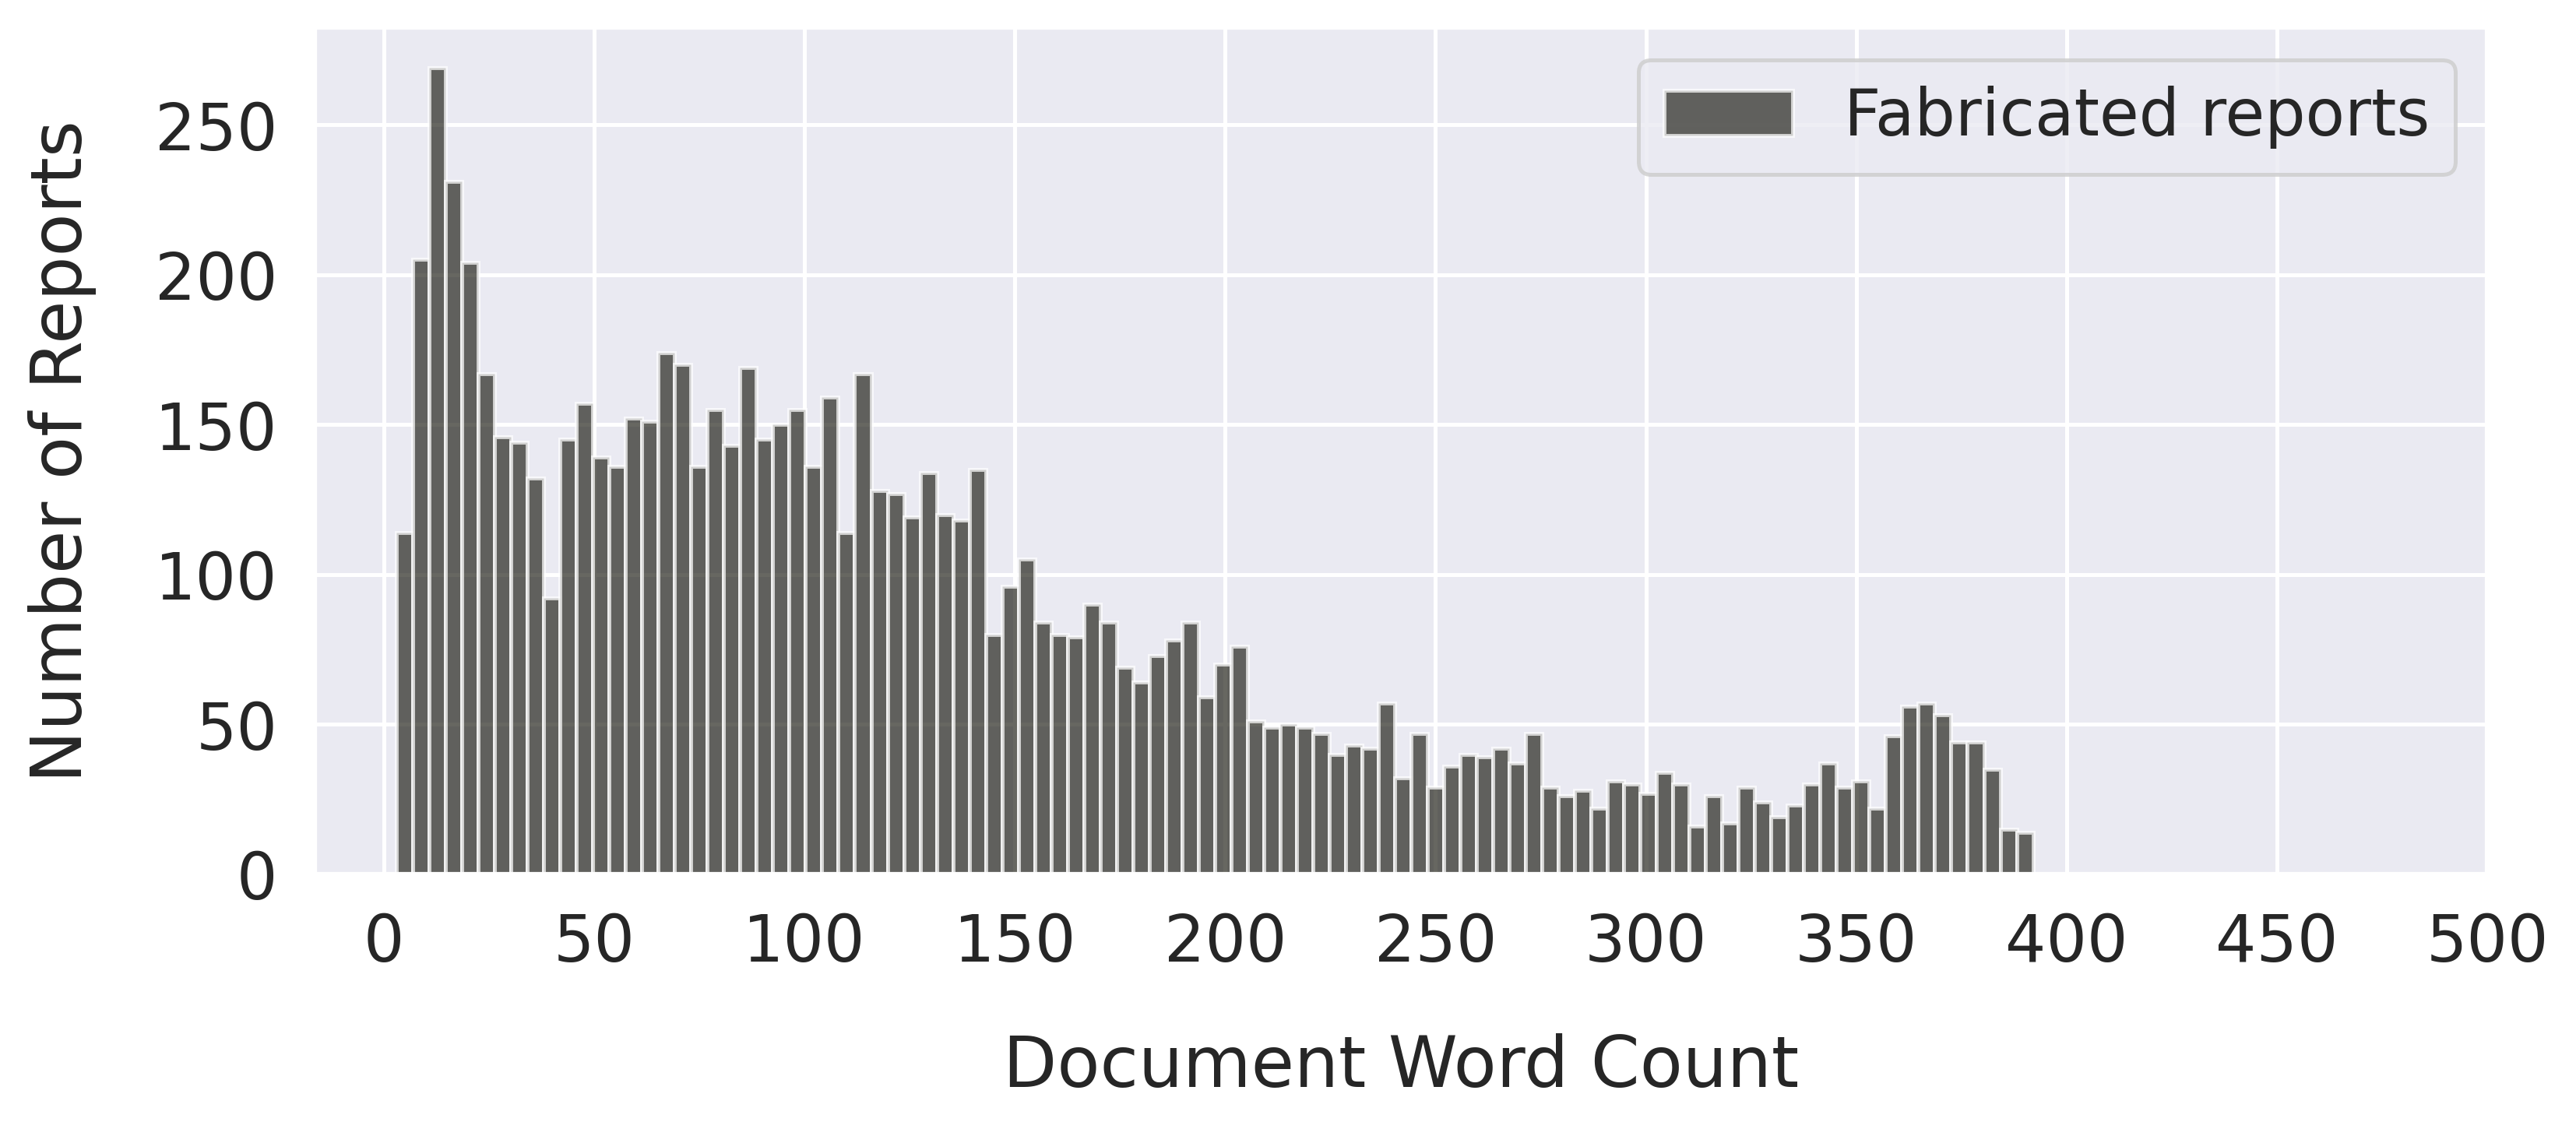

In [ ]:
# Plot a histogram of word counts in the fake narratives
# Remember the real raw data has a mean word count of 62 and 95 percentile value of 309 words
# We expect to see similar distribution for the fake narratives...
doc_lens = [len(d.split()) for d in df_fab_txts.text]
plt.figure(figsize=(10, 4), dpi=360)
plt.hist(doc_lens, bins = 100, color='#26261e', alpha=0.7, label = 'Fabricated reports')
plt.legend(loc = 'upper right')

plt.xlabel("Document Word Count", labelpad = 15)
plt.ylabel("Number of Reports", labelpad = 15)
plt.tick_params(size=6)
plt.xticks(np.linspace(0, 500, 11))
plt.title('', fontdict=dict(size=10))
plt.show()